# Clapping coordination in audience

Assessing the quality of clapping during the applause of the DSQ concert using motion recordings of individual audience members that capture each clap. First section focuses on the Final Applause segment, Beethoven applause assessed below.

The data are the synch-cue aligned claps extracted from the MusicLab app recordings by Ahmet Emin Memis. This notebook visualises the claps in alignement, assess alignment quality with the activity analysis toolbox*, evaluates clapping statistics on subsections of the clapping period 

The final applause shows different clapping patterns, initial scattered enthusiastic clapping, then synchronised clapping for more than a minute, and then scattering again.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [13]:
%reload_ext autoreload

## Load final clapping section
individual claps

In [105]:
os.listdir('./Data/Final_clapping_section_accelerometer')

['final_section_motion.csv',
 'final_section_peaks.csv',
 'final_section_stats.csv',
 'final_section_stats.numbers',
 'final_section_trimmed.csv',
 'final_Stage_events.csv',
 'notes.txt',
 'Video_notes.rtf']

In [106]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
musician_times

TIME       LABEL
0     7.0       Stand
1    11.0         Bow
2    16.0        Team
3    20.0         Bow
4    24.0   De-equipe
5    41.0         Bow
6    53.0     Leaving
7    61.0    Offstage
8    76.0   Returning
9    85.0         Bow
10   93.0        Team
11  101.0         Bow
12  108.0     Leaving
13  111.0    Offstage

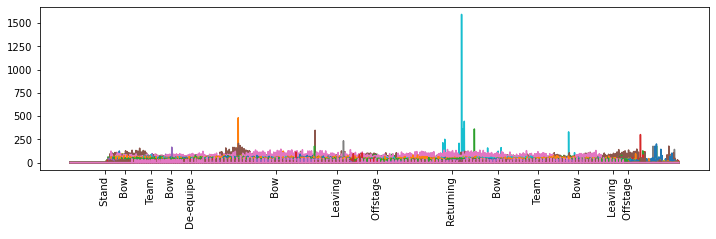

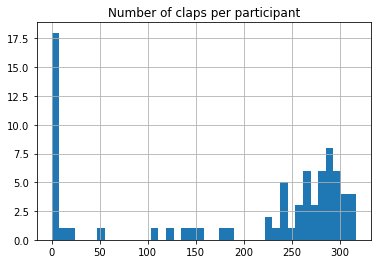

In [107]:
peaks = pd.read_csv('./Data/Final_clapping_section_accelerometer/final_section_peaks.csv')
peaks = peaks.fillna(0)
peaks.drop(columns=['index'],inplace = True)
peaks_IDs = peaks.columns
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.values)
df_claps.plot(figsize = [12,3],legend = False)
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()


In [108]:
# reduce the analysis set to only those recordings with claps.
a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])])

# reduce analysis set to only those responses with claps detected
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
claps_ID = peaks_IDs[a[df_OnlyClaps.sum()>0]] # the participant identifiers matching df_clap columns, in case of need
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

[77, 59]


# look at coincident clapping
Now we check on the alignment of claps across participants by counting how many occure at once, or within the same window of synchrony. This uses the activity analysis toolbox, currently accessible in test version, installation instructions and demo here: https://github.com/finn42/ActivityAnalysis_PythonConversion/blob/main/Activity%20Analysis%20demo%201.ipynb


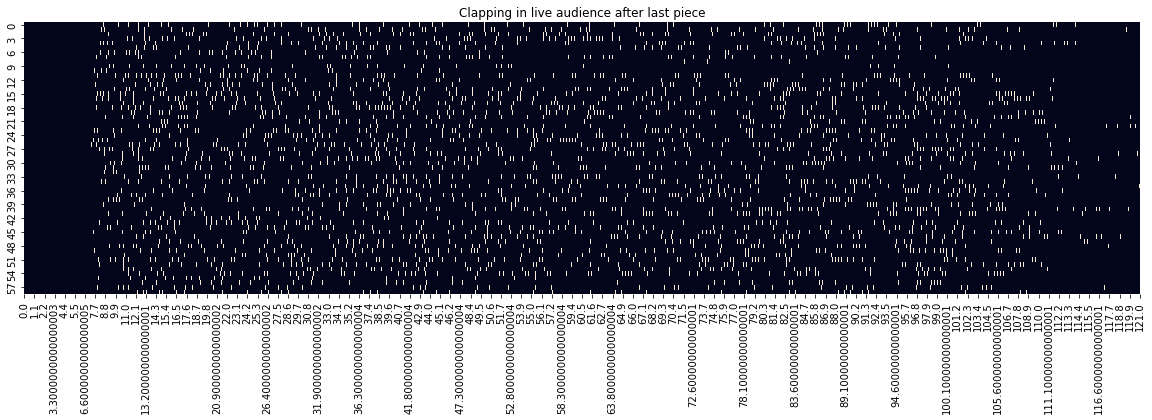

In [109]:
fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_claps.transpose(), ax=ax,vmin=0, vmax=1,cbar=False)

plt.title('Clapping in live audience after last piece')
#plt.savefig('claptimes_finale.png')
plt.show()

# this visualisation does not necessarily show all claps, nor is it easy to interpret their alignment.
# use activity levels instead.

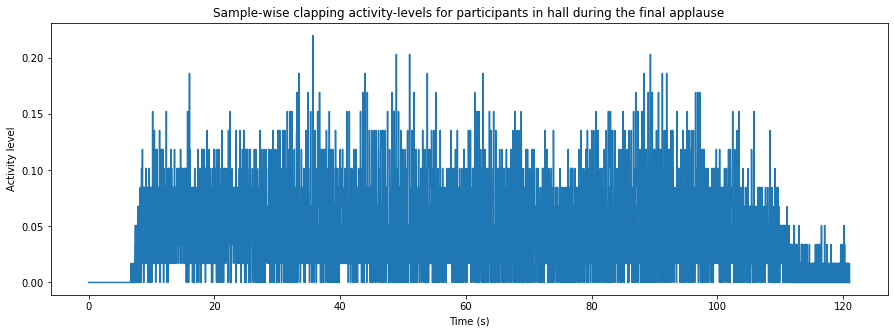

In [110]:
# this figure shows the proportion of participants with a measured clap per sample (50 Hz) 
FrameSize = 0.02 # sample frequency
HopSize = 0.02 # sample frequency
Thresh = 0.5 # claps currently all valued at 1, so catches all claps recorded.
actType = 'UBound' # activity type: all signal values that exceed threshold
Acts = aa.activityCount(df_claps,FrameSize,HopSize,Thresh,actType) 
Acts = Acts.fillna(0)

# reports the total ratio of responses with events (acts) per evaluated frame (here at sample rate, no overlap)
Acts['Total'].plot(figsize=[15,5])
plt.xlabel('Time (s)')
plt.ylabel('Activity level')
plt.title('Sample-wise clapping activity-levels for participants in hall during the final applause')
plt.show()

The activity-level time series takes a while to calculate with this number of frames to assess. Sorry! It's the cost of flexibility. 

This results show some time before any clapping starts (0 activity), then about 10 seconds where there is almost always clapping but it isn't very concentrated. Note: If a lot of people are clapping at rates of around 3 hz without mutual coordination, that should average to 6% of participants clapping per 0.02 second timeframe, with a fair bit of fuzz, and that's what we have here!

At around 17s, the distribution moves up with higher concentrations of alignment, and after 30 there are a lot more high values and frames without anyone clapping than we might expect from uncoordinated clapping. But as our alignment between participants is less than perfect, with precision to around 0.1s, we need to evaluate alignment in larger time frames to catch claping that might have originally coincided. 

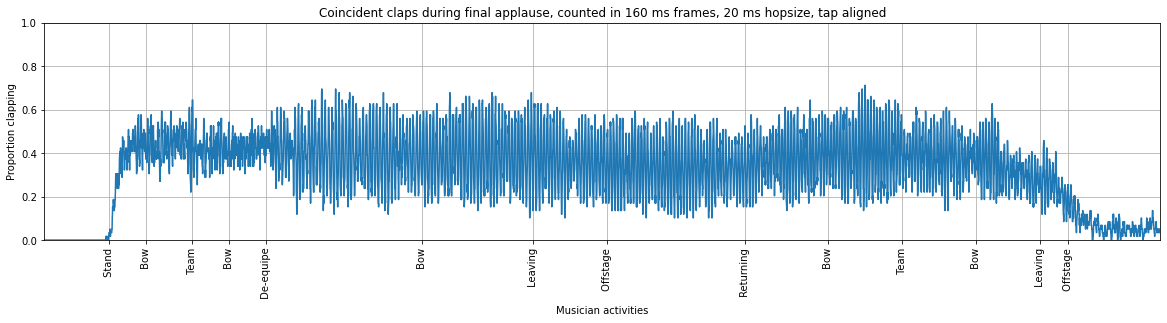

In [111]:
FrameSize = 0.16
HopSize = 0.02
Thresh = 0.5
alpha = 0.01
actType = 'UBound'
ShuffleRange = 2
Iter = 500
Acts = aa.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)
Acts = Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
Acts['Total'].plot(figsize=[20,4])
plt.title('Coincident claps during final applause, counted in 160 ms frames, 20 ms hopsize, tap aligned')
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')

plt.ylabel('Proportion clapping')
plt.xlim([0,121])
plt.ylim([0,1])
plt.grid()

This plot is counting claps in frames of half the estimated median clapping period, the maximum size I'd consider for a well known oscillatory activity. It is sliding at the sample rate. If everyone is clapping, this should capture on average 0.5 or 50% of the population clapping in each frame. The measured activity levels stay around that level, but the widening of range from [0.35,0.55] to [0.2,0.6] suggests participants are coming into phase with each other. Whether it is poorly coordinated participants or alignment issues keeping the activity from zero, we can't say for certain, but that suggests alignment is in there. 

A smaller window of synchrony might be more practical, though, a compromise between inclusivity and clarity of coordination. As 100 ms is the estimated alignment noise, that can server as the minimume for testing alignment.

In [112]:
actType = 'UBound'
HopSize = 0.02
Thresh = 0.5
FrameSize = 0.1
Acts=aa.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)
Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total']) # we drop the ratio to just have the sampled events 
                                    # for the nonparametric local activity test

The local activity test evaluates the alignment of identified events nonparametrically by comparing the activity-level calculated on the orginal alignment to those of alternative alignments. The alternative alignments are generated by nudging each series forward or back by a random amount, sampled uniformly from the ShuffleRange (here one second or 50 samples). From a 1000 or however many alternative alignments, we can define what distribution of activitylevels would be produced across the whole time series if each response maintained the same temporal properties but did not share the same present. This series long distribution is used to non-parametrically assess the how much the original stands out (coordination score, to a max of 16, with 2 equive to alpha = 0.01). 

This same interative alternative process can also be used to assess local alignment. By keeping the shuffling range small, we can estimate how alignment at any given moment stands out from what should happen by change given local activity rates. A lot of interesting activity types are highly heteroskedastic for reasons outside of what might be coordinating events, so it's important to assess coincidences with some recognition of that sensitivity. 

The plot below will show local peaks in alignmed activity with dots. If the dots are red, that is because the global assessment of coordination rejects the null hypothesis. If the dots are yellow, that means the distribution of activity levels across the whole time series does not strongly distinguish from alignments produced by alternative alignments, i.e. coordination is not clear. 

Note: A failed global coordination test doesn't mean that there is nothing influencing mutual coordination, only that any coordination influence is not so strong and consistent to produce a substantial shift in activity levels over a substantial portion of the measure time interval. Interpret with the test's short comings in mind.

In [113]:
ShuffleRange = 1
Iter = 1000
alpha = 0.005
tic = time.time()
stest = aa.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
print(time.time()-tic)
stest

53.7271945476532


{'pvalue': 0.0,
 'MeasuredResults':         Activity-levels  Local_p  Surprise
 Time                                      
 0.05                0.0    0.385  0.203414
 0.07                0.0    0.306  0.355638
 0.09                0.0    0.257  0.461056
 0.11                0.0    0.222  0.544627
 0.13                0.0    0.193  0.621316
 ...                 ...      ...       ...
 120.93              2.0    0.683 -0.333361
 120.95              3.0    0.894 -0.926032
 120.97              3.0    0.900 -0.954243
 120.99              3.0    0.907 -0.989124
 121.01              3.0    0.914 -1.026448
 
 [6049 rows x 3 columns],
 'Models':         0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
 Time                                                      ...                  
 0.05    0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  1.0  2.0  1.0   
 0.07    0.0  0.0  1.0  0.0  0.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  2.0  2.0   
 0.09    0.0  0.0  1.0  0.0  1.

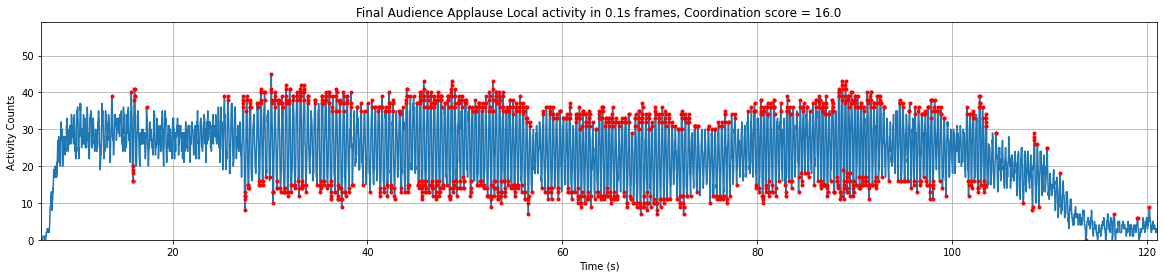

In [114]:
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,59])
plt.xlim([6.5,121])
plt.xlabel('Time (s)')
# plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
# plt.xlabel('Musicians activities during applause (time~120s)')
plt.ylabel('Activity Counts')
plt.grid()
plt.title('Final Audience Applause Local activity in ' + str(FrameSize) + 's frames, Coordination score = '+str(round(stest['CoordScore'],3)))
#plt.savefig('Applause_Final_Alignment_005_musicanEvents.png',dpi = 400)
plt.show()

This figure reports the number of participants measured as clapping in a sliding 100 ms window of synchrony, with red point marking when these coincidences exceed a probabilistic threshold of 0.005 for accidental alignment (given the local rates of claps on a shuffle range of 1 s and 1000 alternatives). 

The number of claps rises quickly and maintains a blury range of 23-36 of 59 with few extreme coincidences (13.7, 15.7-16.2), until coordinated clapping starts to coalesce from 25.3 s and reaches a steady regularity at 27.2 s. This extreme alignment continues through to 103.5 s, with a few deviations (56.8-56.8, 74.1-75.0, 77.7-79.1, 93.0-94.3, 99.3-101.5). 

In [20]:
# this cell is just to peak at the time points where the extreme activity drops out. 
B.iloc[270:320] #initial peaks and begining of sustained coordination
# B.iloc[-50:] # end of sustained alignment and final peaks
#B.iloc[840:850] # Deviations 1
#B.iloc[1150:1200] # Deviations 2
#B.iloc[1440:1460] # Deviations 3
#B.iloc[1500:1520] # Deviations 4

Activity-levels  Local_p  Surprise
Time                                     
6.03               0.0    0.999 -2.999565
6.05               0.0    0.999 -2.999565
6.07               0.0    0.999 -2.999565
6.09               0.0    0.999 -2.999565
6.11               0.0    0.999 -2.999565
6.13               0.0    0.999 -2.999565
6.15               0.0    0.999 -2.999565
6.17               0.0    0.999 -2.999565
6.19               0.0    0.999 -2.999565
13.77             39.0    0.998 -2.698101
15.77             40.0    0.998 -2.698101
15.89             19.0    0.004  2.396199
15.93             18.0    0.002  2.698101
15.95             16.0    0.001  2.999565
15.97             16.0    0.001  2.999565
16.07             38.0    0.999 -2.999565
16.09             41.0    0.999 -2.999565
16.11             41.0    0.999 -2.999565
16.13             39.0    0.998 -2.698101
16.15             39.0    0.999 -2.999565
25.33             39.0    0.999 -2.999565
25.67             38.0    0.996 -2.396199
25.69             39.0    0.999 -2.999565
27.21             36.0    0.998 -2.698101
27.23             37.0    0.999 -2.999565
27.25             39.0    0.999 -2.999565
27.27             38.0    0.999 -2.999565
27.39             13.0    0.001  2.999565
27.41             12.0    0.001  2.999565
27.43             11.0    0.001  2.999565
27.45              8.0    0.001  2.999565
27.47             12.0    0.001  2.999565
27.59             39.0    0.999 -2.999565
27.61             38.0    0.999 -2.999565
27.63             38.0    0.999 -2.999565
27.65             35.0    0.998 -2.698101
27.77             14.0    0.002  2.698101
27.79             15.0    0.003  2.521574
27.81             14.0    0.001  2.999565
27.93             37.0    0.999 -2.999565
27.95             36.0    0.999 -2.999565
27.97             36.0    0.999 -2.999565
27.99             38.0    0.999 -2.999565
28.01             36.0    0.997 -2.521574
28.75             37.0    0.996 -2.396199
28.77             36.0    0.998 -2.698101
28.87             15.0    0.001  2.999565
28.91             16.0    0.003  2.521574
28.93             15.0    0.001  2.999565
29.03             37.0    0.996 -2.396199

Testing out plausible windows of synchrony (framesize for counting concurrent claps) given the uncertainty around noise in the alignment. Tried a range of 40 ms (two samples) to 200 ms. The agregate coordination score max out for all conditions and the activity level peaks (in red) overlap substantially across this parameter range (for a threshold of alpha = 0.01). However, the larger windows blur the lows substantially, shifting the distribution of activity levels quite high. As a compromise between known precision issues and clarity of activity-counts, we can settle on the compromise with 100 ms (0.1 s) as window of synch. 

In [21]:
windows = np.arange(0.04,0.2,0.04)
windows

array([0.04, 0.08, 0.12, 0.16])

48.824891805648804
99.93438935279846
154.67953157424927
213.07739448547363


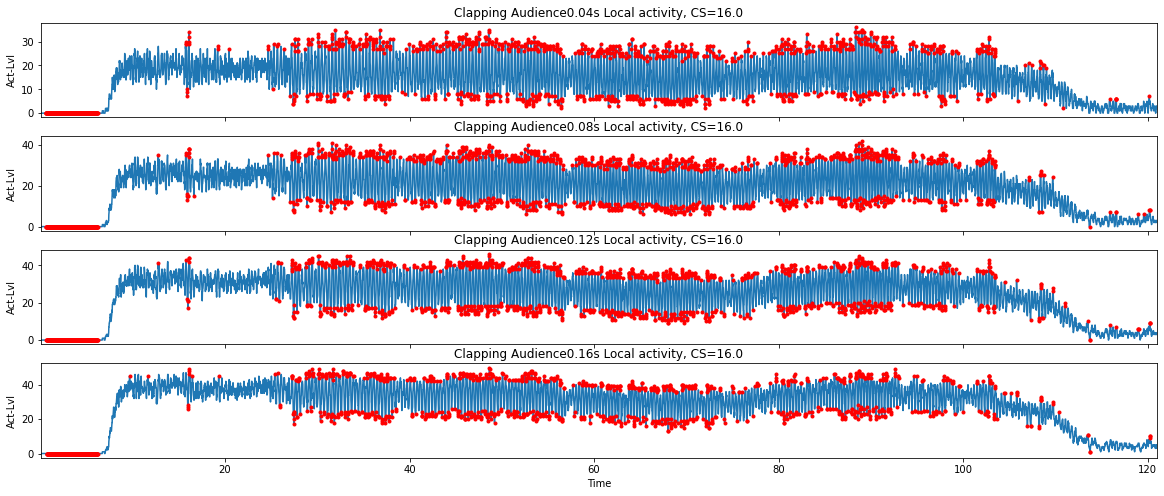

In [22]:
fig, axs = plt.subplots(len(windows),1, sharex='all',figsize=(20,len(windows)*2))
tic = time.time()
    
for j in range(len(windows)):
    FrameSize = windows[j]
    stest = aa.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot(ax=axs[j])
    if C >=-np.log10(alpha):
        B['Activity-levels'].plot(style='r.',ax=axs[j])
    else:
        B['Activity-levels'].plot(style='y.',ax=axs[j])
#     axs[j].set_ylim(0,19)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')

    axs[j].set_title('Clapping Audience' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
    print(time.time()-tic)
#     os.chdir('./peaks')
#     stest['ActivityPeaks'].to_csv(work+'_PL_'+ str(FrameSize) + 's_peaks.csv')
#     os.chdir('..')
#os.chdir('./plots')
plt.savefig('L_P_claps_aligned.png',dpi = 400)
#os.chdir('..')
plt.show()

Regardless of window of synch size, it seems these claps are showing substantial coordination, and the local test helps identify when that coordination comes into focus. Very nice to see this come through the alignment noise (which is still way lower than what it would have been without the synchrony clue.)

# Clap regularity check

How to check on how each participant is clapping over the course of these 2 minutes of applause. Specifically, we want to know how fast they are clapping, and how regularly. To do this, we focus on the interclap interval, the time from one clap to the next.

Statistics on the interclapinterval, or any interval for a near regular behaviour, can be tricky. For a behaviour like claping, it's quite common for people to skip claps, making a bimodal distribution of clap intervals with a lot of space between the natural variation that is in the average human's entrained clapping timing. This is an argument for using non-parametric descriptors of distributions, like the median for central tendency and the inter-quartile for dispersion. But if the outliers are of interest, the mean and STD can still be useful, particularly on contrast their non-parametric cousins. 


### Are clapping patterns different during asynchronous clapping and synchronous clapping?
We will compare stats on a few excerpts of claps with Friedman 1 way test in pinguin (repeated measures, nonparametric)

Check clapping regularity in three 3s intervals per condition: 

1. Initial uncoordinated clapping interval (7s-25s)
2. Lasting coordinated interval (30s-100s)
3. Mixed intervals (75s-82s?, 100s onward) ? 

Dependent Traits of interest:
1. Median ICI
2. ICI std 
3. ICI quartile difference
4. Median ICI deviance (avg distance from each clap to the closest ISO sequence clap, after max alignment, need to write function TODO)

Independent traits:
Interval onset, Interval condition, participant, 


In [115]:
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [116]:
# build database of clapping stats over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
sampletimes = [10, 14, 18, 20, 35, 50, 65, 80, 104,108,112]
sampleconditions = ['Initial','Initial','Initial','Initial','Synched','Synched','Synched','Synched','End','End','End']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        #if len(ici)>0:
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)
    
# to_numeric
cols = ['ICI_Mean','ICI_Median','ICI_Quartiles','ICI_STD']
for c in cols:
    Clap_Style.loc[:,c] = pd.to_numeric(Clap_Style[c])

In [117]:
Clap_Style#.loc[500:505]

Interval_start Interval_duration Interval_condition Participant  \
0               10                 3            Initial           0   
1               10                 3            Initial           1   
2               10                 3            Initial           2   
3               10                 3            Initial           3   
4               10                 3            Initial           4   
..             ...               ...                ...         ...   
644            112                 3                End          54   
645            112                 3                End          55   
646            112                 3                End          56   
647            112                 3                End          57   
648            112                 3                End          58   

     ICI_Median  ICI_Quartiles  ICI_Mean   ICI_STD Clap_Count  
0          0.36           0.04  0.368571  0.032367          8  
1          0.38           0.08  0.354286  0.052554          8  
2          0.32           0.02  0.322500  0.016690          9  
3          0.27           0.02  0.272000  0.019322         11  
4          0.38           0.18  0.433333  0.099331          7  
..          ...            ...       ...       ...        ...  
644         NaN            NaN       NaN       NaN          1  
645         NaN            NaN       NaN       NaN          0  
646         NaN            NaN       NaN       NaN          0  
647        0.34           0.20  0.366667  0.102632          4  
648         NaN            NaN       NaN       NaN          0  

[649 rows x 9 columns]

In [118]:
# clear out nans in case they make the functions panic
cstats = Clap_Style.where(Clap_Style['Clap_Count']>0)
cstats = cstats.dropna()

In [119]:
Clap_Style['ICI_Median'].sum()

206.34000000000003

In [120]:
cstats

Interval_start Interval_duration Interval_condition Participant  \
0               10                 3            Initial           0   
1               10                 3            Initial           1   
2               10                 3            Initial           2   
3               10                 3            Initial           3   
4               10                 3            Initial           4   
..             ...               ...                ...         ...   
630            112                 3                End          40   
633            112                 3                End          43   
636            112                 3                End          46   
637            112                 3                End          47   
647            112                 3                End          57   

     ICI_Median  ICI_Quartiles  ICI_Mean   ICI_STD Clap_Count  
0          0.36           0.04  0.368571  0.032367          8  
1          0.38           0.08  0.354286  0.052554          8  
2          0.32           0.02  0.322500  0.016690          9  
3          0.27           0.02  0.272000  0.019322         11  
4          0.38           0.18  0.433333  0.099331          7  
..          ...            ...       ...       ...        ...  
630        0.36           0.12  0.356667  0.081404          7  
633        0.38           0.00  0.405000  0.064031          5  
636        0.38           0.24  0.423333  0.117587          7  
637        0.41           0.18  0.490000  0.221540          7  
647        0.34           0.20  0.366667  0.102632          4  

[523 rows x 9 columns]

ICI_Median
                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.108  1.959  94.041  5.793  0.004


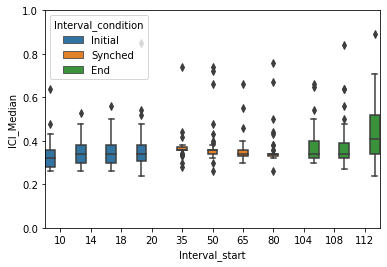


ICI_Quartiles
                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.012  1.959  94.041  0.587  0.554


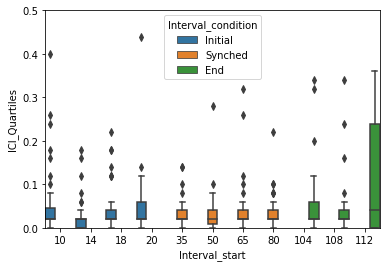

In [121]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('ICI_Median')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('\nICI_Quartiles')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

In [122]:
cstats['ICI_Median'].dtype.kind

'f'

This suggests that the interval condition (synchronise clapping vs befor or after) is significantly impacting the median clapping rate. However, these condition are not so easily distinguished when looking at the (conservative) variation in interclap intervals. These plots make these differences more visible. 

Do less conservative statistics show the same trends between conditions? 

ICI_Mean
                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.088  1.959  94.041  4.625  0.013


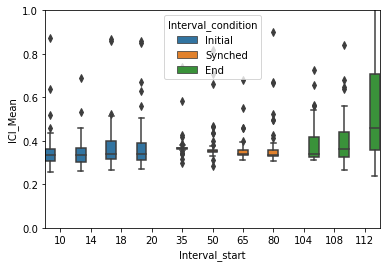


ICI_STD
                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.068  1.958  92.042  3.413  0.038


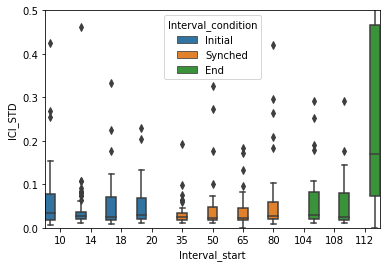

In [123]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Mean', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('ICI_Mean')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Mean",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()

#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_STD', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('\nICI_STD')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_STD',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

The statistics on these excerpts of the series show some a similar story for the Means, and a bit more difference in the dispersion (STD), though the contranst is mostly between the last segment tested and the interclapinterval as participants slow their claps to a stop. 


# Transition to synch clapping

Those statistics that showed substantive constrats between clapping behaviour intervals can be used to evaluate when participants transitions from clapping independently to clapping together. 

In [124]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[5:10]

0     1     2     3     4     5     6     7    8     9   ...    49  \
5.0    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  ...   NaN   
5.5    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN  ...   NaN   
6.0    NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.42  NaN   NaN  ...   NaN   
6.5    NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.39  NaN   0.4  ...   NaN   
7.0    NaN  0.46   NaN   NaN  0.44   NaN   NaN  0.36  NaN  0.26  ...   NaN   
7.5   0.34  0.36   NaN   NaN  0.39  0.31  0.29  0.36  NaN  0.28  ...   1.1   
8.0   0.32  0.37   NaN  0.36  0.42  0.36   0.3  0.36  NaN  0.28  ...  0.44   
8.5   0.32  0.37  0.36  0.32  0.42  0.28   0.3  0.36  NaN  0.28  ...  0.28   
9.0   0.32  0.37  0.34  0.32  0.39  0.28   0.3  0.36  NaN  0.28  ...  0.28   
9.5   0.33  0.37  0.34  0.29  0.37  0.28  0.31  0.36  NaN   0.3  ...  0.26   
10.0  0.33   0.4  0.34  0.28   0.4  0.28  0.32  0.35  NaN  0.44  ...  0.26   

       50    51    52    53    54    55    56    57   58  
5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN  
5.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN  
6.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN  
6.5   NaN   NaN  0.38   NaN   NaN   NaN   NaN  0.37  NaN  
7.0   NaN  0.27  0.36   NaN   NaN  0.35  0.42  0.34  NaN  
7.5   NaN  0.27  0.33   0.5  0.86  0.31   0.4  0.34  NaN  
8.0   NaN  0.27  0.31  0.49  0.86  0.34  0.39  0.36  NaN  
8.5   0.3  0.28  0.31  0.49  0.98   0.3  0.38  0.31  NaN  
9.0   0.3  0.28   0.3  0.48  0.86  0.28  0.39  0.28  NaN  
9.5   0.3  0.28  0.28  0.49  0.39  0.28  0.38  0.28  NaN  
10.0  0.3  0.28   0.3  0.49  0.36   0.3  0.38  0.28  NaN  

[11 rows x 59 columns]

<AxesSubplot:title={'center':'Local claping ICI median, mean in black, std in red'}>

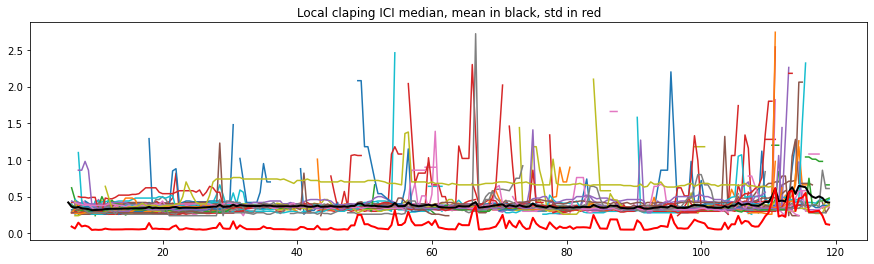

In [125]:
# to get an idea of what values these take
Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, mean in black, std in red')
B = Clap_Feats.mean(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)

We know that people stop clapping for short periods and long, producing extreme outliers in the data, so to reduce their impact, we can calculate the median and quartile time series instead. 

In [126]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats.loc[:10]

Median LowerQ UpperQ Midrange NotNa_C   NotNa_p
6.0    0.42   0.42   0.42      0.0     1.0  0.016949
6.5    0.37   0.28   0.39     0.11    15.0  0.254237
7.0    0.34    0.3    0.4      0.1    34.0  0.576271
7.5    0.32   0.29   0.38     0.09    47.0   0.79661
8.0    0.31   0.28   0.36     0.08    49.0  0.830508
8.5     0.3   0.28   0.36     0.08    52.0  0.881356
9.0     0.3   0.28   0.36     0.08    52.0  0.881356
9.5     0.3   0.28   0.34     0.06    54.0  0.915254
10.0    0.3   0.28   0.34     0.06    55.0  0.932203

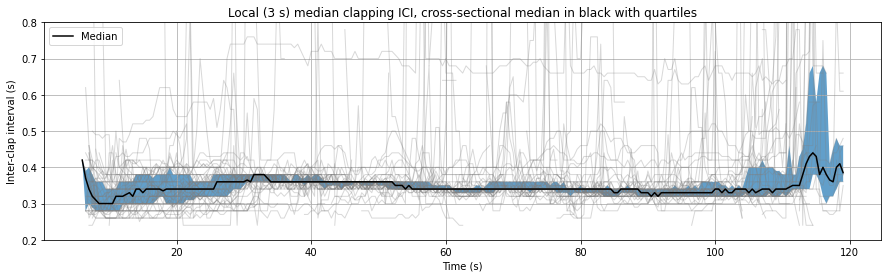

In [127]:
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS.png',dpi=400)
plt.show()


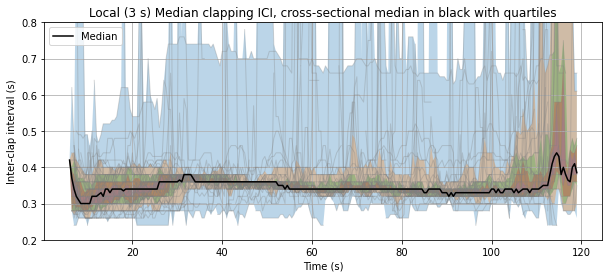

In [133]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
t_interval = 3
cntiles = np.array([0,0.1,0.2,0.3,0.4])
for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)

for pc in cntiles:
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
            df_spans.loc[i,:] = these_stats
    df_spans = df_spans.dropna()

    x = np.array(df_spans.index)
    y1 = np.array(df_spans.Lower,dtype=np.float32)
    y2 = np.array(df_spans.Upper,dtype=np.float32)
    ax.fill_between(x,y1,y2,alpha = 0.3,label=str(pc))

plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_medians_CentileTS.png',dpi=400)
plt.show()


This looks very convincing. Initially, participants median clapping rates were similar but spread out. At some point around 30 s, the quartiles contract to the median line and this continues through the synchronous period. This indicates that at least half of participants were keeping their inter-clapping intervals to within a sample of each other. 

Also noticable here is the slow decrease in interclapinterval lenght, corresponding to a gradual increase in claping rate. In a little over 60 seconds, the median local median interclap interval has shifted by more than a sample. This demonstraits sustained mutual entrainment. 

Next we have to consider wehther these shifts in clapping behaviour might be reactions to what is happening in front of the applauding audience. 

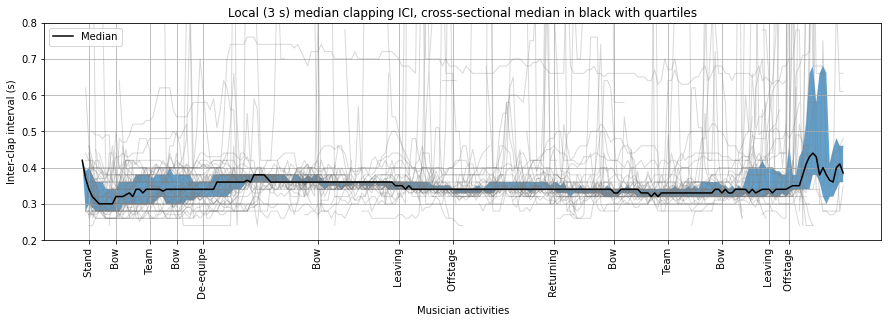

In [129]:
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS_ME.png',dpi=400)
plt.show()


It looks like the coordinated clapping only begins when the musicians attentions shift from the audience to getting off stage. Could it be that audiences switch to the more salient, more obviously deliberate clapping behaviour to request a return of their attention?

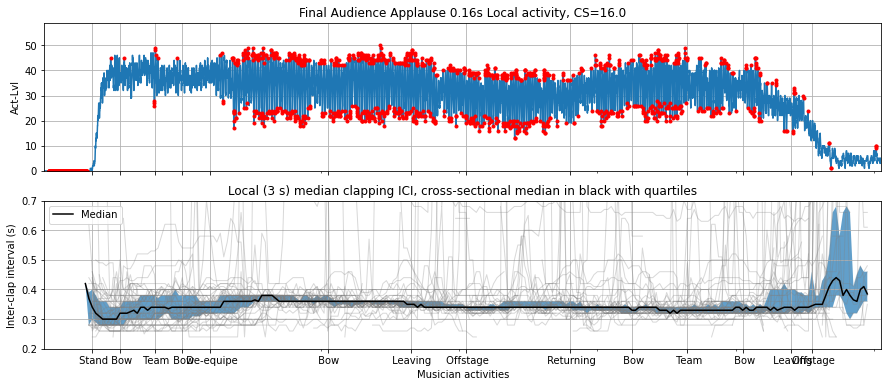

In [64]:
# here is the clapping phase coordination and rate adaptation in one output plot.

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=[15,6])

A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
A['Activity-levels'].plot(ax=ax1)
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.',ax=ax1)
else:
    B['Activity-levels'].plot(style='y.',ax=ax1)
ax1.set_ylim([0,59])
ax1.set_xlim([A.index[0],A.index[-1]])
ax1.set_ylabel('Act-Lvl')
ax1.grid()
ax1.set_title('Final Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
# plt.savefig('Applause_Final_Alignment_01.png',dpi = 400)
# plt.show()



df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax2)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black",ax = ax2)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax2.fill_between(x,y1,y2,alpha = 0.7)
ax2.set_ylim([0.2,0.7])
ax2.grid()
#plt.xlabel('Time (s)')
ax2.set_xticks(musician_times.TIME.values)
ax2.set_xticklabels(musician_times.LABEL.values)
ax2.set_xlabel('Musician activities')
ax2.set_ylabel('Inter-clap interval (s)')
ax2.set_title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_ACT.png',dpi=400)
plt.show()


For the sake of curiousity, we can run the same evaluation on the local ici means. 

(0.0, 0.8)

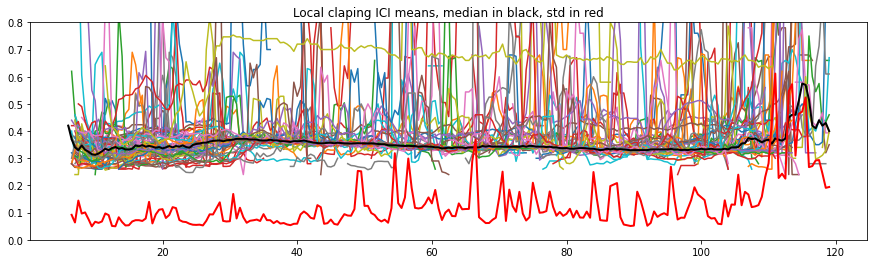

In [73]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmean(ici)
            #these_claps[partn]=np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI means, median in black, std in red')
#plt.title('Local claping ICI MiddleRange, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

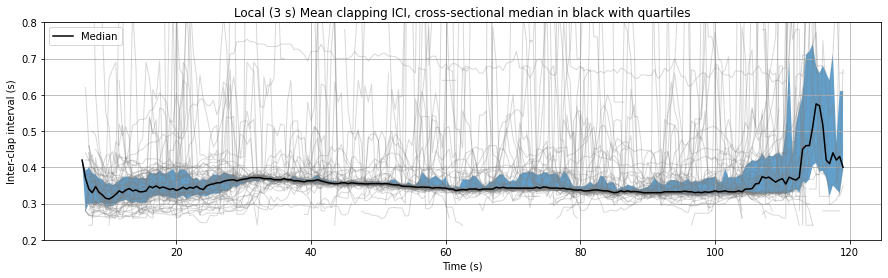

In [53]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_means_QuartileTS.png',dpi=400)
plt.show()


This shows a similar story to the medians with a few interesting deviations. As mentioned above, differences between the median and the mean are mostly due to outliers that break from the assumptions of normality. However, it also allows some smotion of values that were sample-rate-chunky in the median plots. 

1) the decrease in interclap interval is smooth, not stepwise. Might be worth fiting with a linear equation to see how this drift compares to the estimates of models. 

2) the most obvious difference between local means and medians is in the upper-mid quartile (between 50% and 75%) which bumps up from the median line starting from 56 s. As we know their median ICIs are still close the the global median through this period, these increases suggest that participants are skiping claps rather than slowing down. Might there be a reason for that change in behaviour?

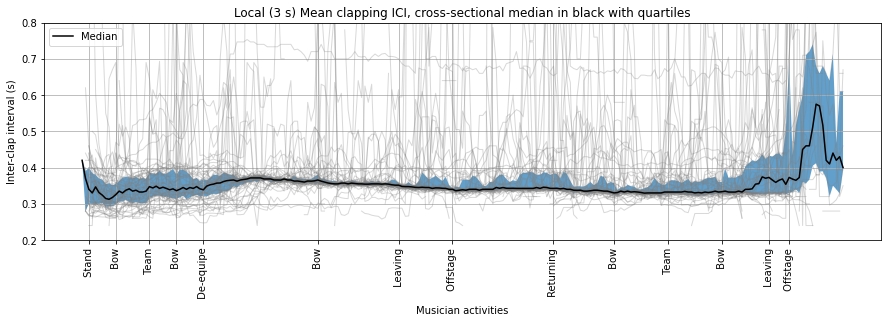

In [54]:
# local means, in quartiles TS, on Musicians Event timeline 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_ICI_means_QuartileTS_ME.png',dpi=400)
plt.show()


This makes it look like the skipped claps show up and stick around while the musicians are leaving or off stage. Where these the claps of people less certain or less eager to call them back for more bows? It is interesting how some poeple were inclined to lessen their effort during this time while others were not. It would be interesting to look into the questionnair responses of each group. 

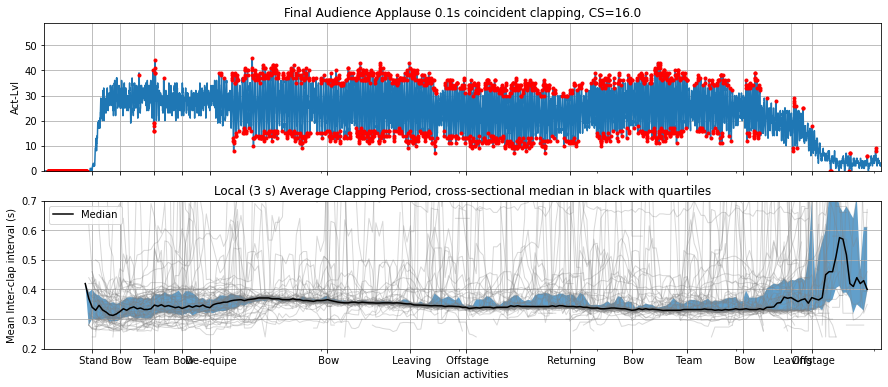

In [719]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=[15,6])

A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
A['Activity-levels'].plot(ax=ax1)
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.',ax=ax1)
else:
    B['Activity-levels'].plot(style='y.',ax=ax1)
ax1.set_ylim([0,59])
ax1.set_xlim([A.index[0],A.index[-1]])
ax1.set_ylabel('Act-Lvl')
ax1.grid()
ax1.set_title('Final Audience Applause ' + str(FrameSize) + 's coincident clapping, CS='+str(round(stest['CoordScore'],3)))
# plt.savefig('Applause_Final_Alignment_01.png',dpi = 400)
# plt.show()



df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax2)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black",ax = ax2)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax2.fill_between(x,y1,y2,alpha = 0.7)
ax2.set_ylim([0.2,0.7])
ax2.grid()
#plt.xlabel('Time (s)')
ax2.set_xticks(musician_times.TIME.values)
ax2.set_xticklabels(musician_times.LABEL.values)
ax2.set_xlabel('Musician activities')
ax2.set_ylabel('Mean Inter-clap interval (s)')
ax2.set_title('Local (3 s) Average Clapping Period, cross-sectional median in black with quartiles')
plt.savefig('FinalApplause_Local_Mean_ICI_ACT.png',dpi=400)
plt.show()


Now to check on whether the dispersion measures still fail to distinguish between independent and coordinated clapping

<AxesSubplot:title={'center':'Local claping ICI dispersion (quartiles), median in black, std in red'}>

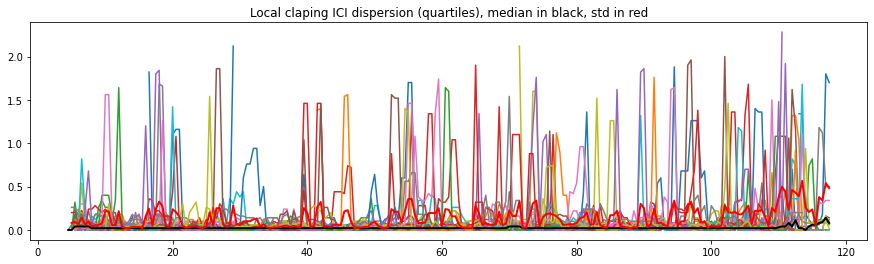

In [77]:
# build database of clapping behaviour over measured intervals
t_interval = 3
sampletimes = np.arange(0,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI dispersion (quartiles), median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
#plt.ylim([0,0.2])

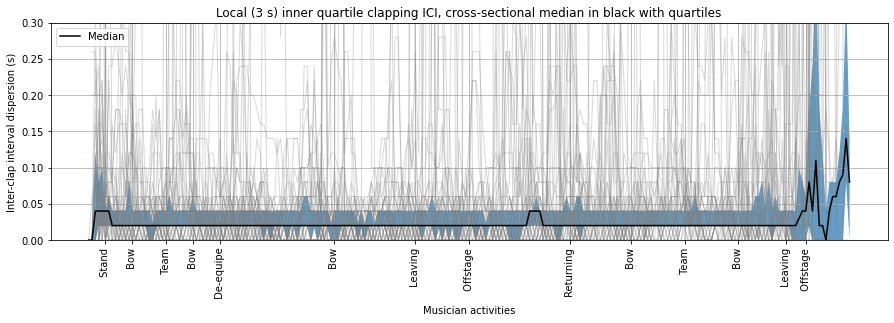

In [78]:
# pull out the quartile time series, allowing for nans
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

fig,ax = plt.subplots(1,1,figsize=[15,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0,0.3])
plt.grid()
#plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.xlabel('Musician activities')
plt.ylabel('Inter-clap interval dispersion (s)')
plt.title('Local (3 s) inner quartile clapping ICI, cross-sectional median in black with quartiles')
#plt.savefig('FinalApplause_Local_ICI_quartiles_QuartileTS_ME.png',dpi=400)
plt.show()


Yup, it looks like there isn't a systematic shift in interclap-interval regularity between the times participants are clapping independently and when they are clapping together. HOWEVER the innerquartile dispersion is tiny, right at one sample here, so we know that we are hitting the limit of differences we can measure at this sample rate. If there is a difference reflecting the change of clapping context, it is smaller than 50 ms.

(0.0, 0.2)

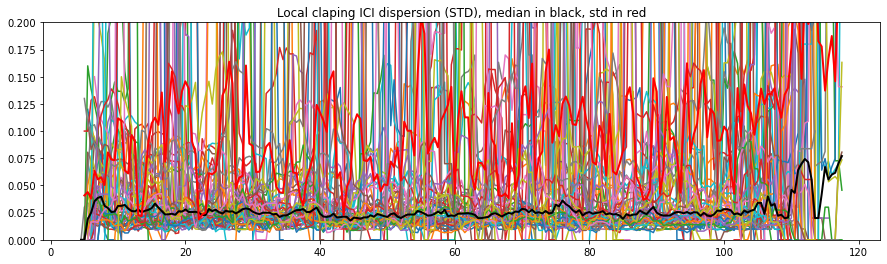

In [79]:
# build database of clapping behaviour over measured intervals
t_interval = 3
sampletimes = np.arange(0,121-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanstd(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI dispersion (STD), median in black, std in red')
B = Clap_Feats.median(axis=1)

B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.2])

Evaluating the same on the STD does give us a little bit of a chance to see changes smaller than sample rate, but this doesn't look very convincing either. It looks like participants were consistent enough that our measurements can not tell the difference. 

# beethoven applause

A small ammount of coordinated clapping seems to be audible in the applause to the first peice of the concert, a late beethoven string quartet. We can pass it through the same test to see what comes through

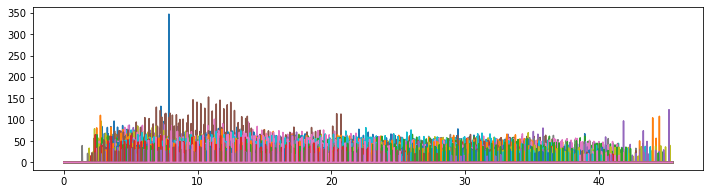

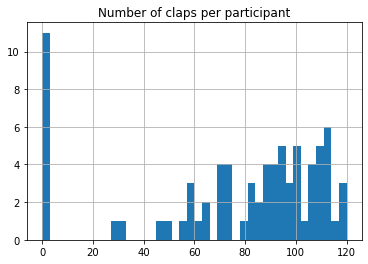

[77, 66]


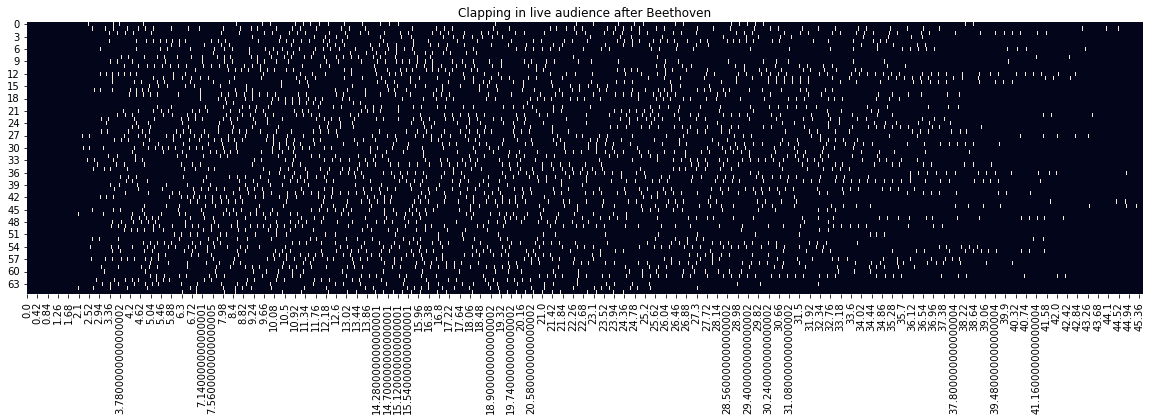

In [150]:
peaks = pd.read_csv('./Data/beethoven_clapping_section_accelerometer/beethoven_section_peaks.csv')
peaks.drop(columns=['index'],inplace = True)
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.values)
df_claps.plot(figsize = [12,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)

df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_claps.transpose(), ax=ax,vmin=0, vmax=1,cbar=False)
#plt.xticks(concert_times.datetime_concert,concert_times.event, rotation='vertical')
#freq = int(round(len(aud_df)/len(ax.get_xticks())))
#ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Clapping in live audience after Beethoven')
#plt.savefig('claptimes_finale.png')
plt.show()

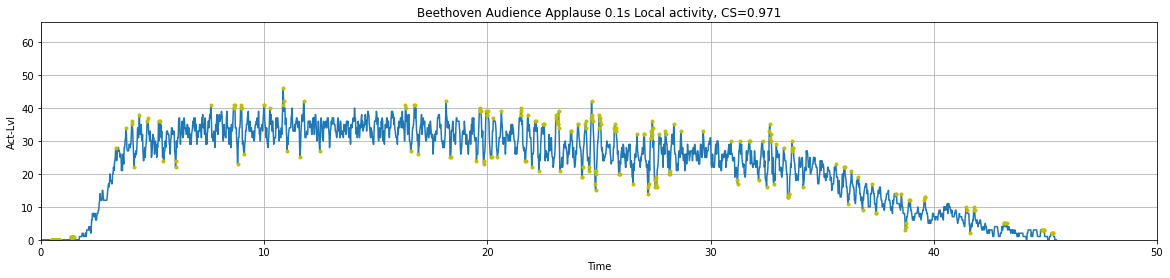

In [85]:
actType = 'UBound'
HopSize = 0.02
Thresh = 0.5
FrameSize = 0.1
# Acts=act.activityCount(df_claps.loc[3:35,:],FrameSize,HopSize,Thresh,actType)
Acts=aa.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)

Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
ShuffleRange = 1
Iter = 1000
alpha = 0.05

stest = aa.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,66])
plt.xlim([0,50])
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Beethoven Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Beethoven_Alignment_01_sub.png',dpi = 400)
plt.show()

On the scale of the whole excerpt, coordination in clapping isn't standing out. And when evaluating an excerpt of this (from around 7s to 35s), coordination doesn't score well either. And yet looking at the plot, we see this interval of oscillations in activity that look a lot like coordinated clapping, if maybe by a subset of the audience. Given the limitations of the activity test, it might still be worth sectioning the participants to see if we can concentrate that audible behaviour. 

In [151]:
# build database of clapping behaviour over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
sampletimes = [5, 10, 15, 20, 25, 32]
sampleconditions = ['Initial','Initial','Initial','Synched','Synched','Synched']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)
    
# to_numeric
cols = ['ICI_Mean','ICI_Median','ICI_Quartiles','ICI_STD']
for c in cols:
    Clap_Style.loc[:,c] = pd.to_numeric(Clap_Style[c])

                      Source     W  ddof1   ddof2     F  p-unc
Friedman  Interval_condition  0.36  0.969  62.031  36.0    0.0


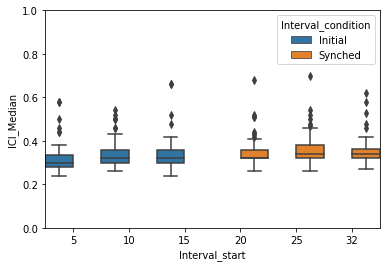

                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.007  0.969  62.031  0.435  0.506


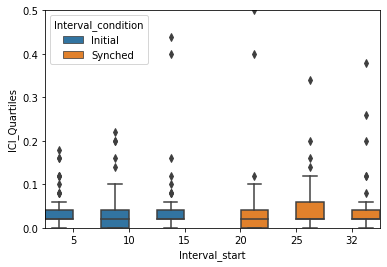

In [152]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

                      Source     W  ddof1   ddof2     F  p-unc
Friedman  Interval_condition  0.36  0.969  62.031  36.0    0.0


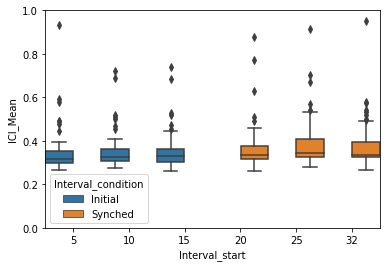

                      Source      W  ddof1   ddof2      F  p-unc
Friedman  Interval_condition  0.004  0.969  61.031  0.247  0.613


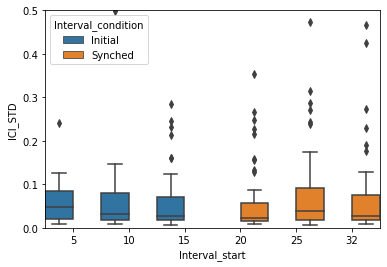

In [153]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Mean', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Mean",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_STD', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_STD',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

(0.0, 0.8)

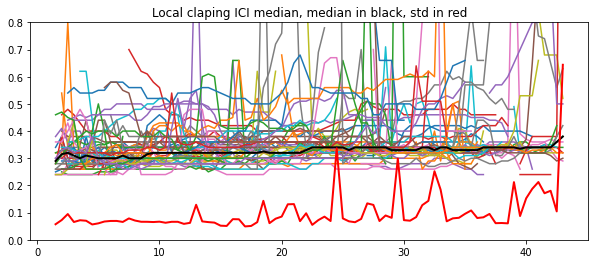

In [154]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,45-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[10,4])
plt.title('Local claping ICI median, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

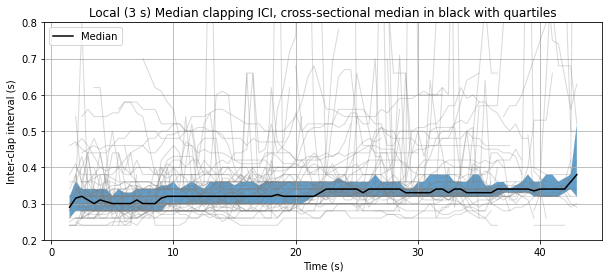

In [155]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('BeethovenApplause_Local_ICI_medians_QuartileTS.png',dpi=400)
plt.show()


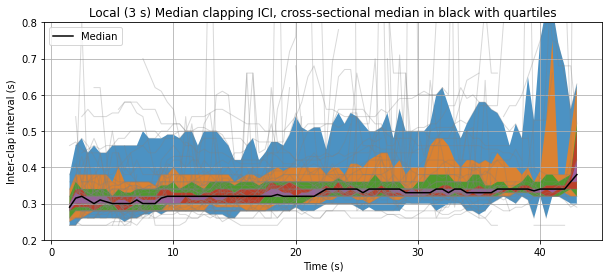

In [156]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
t_interval = 3
cntiles = np.array([0,0.1,0.2,0.3,0.4])+0.05
for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)

for pc in cntiles:
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
            df_spans.loc[i,:] = these_stats
    df_spans = df_spans.dropna()

    x = np.array(df_spans.index)
    y1 = np.array(df_spans.Lower,dtype=np.float32)
    y2 = np.array(df_spans.Upper,dtype=np.float32)
    ax.fill_between(x,y1,y2,alpha = 0.8)

plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('BeethovenApplause_Local_ICI_medians_CentileTS.png',dpi=400)
plt.show()


(0.0, 0.8)

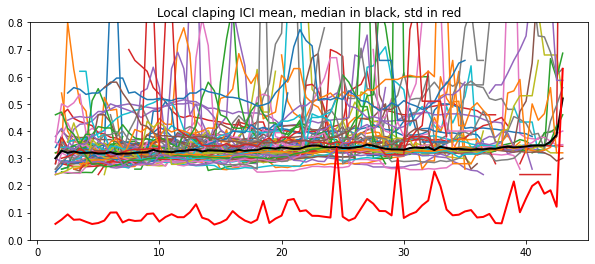

In [67]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,45-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmean(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[10,4])
plt.title('Local claping ICI mean, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

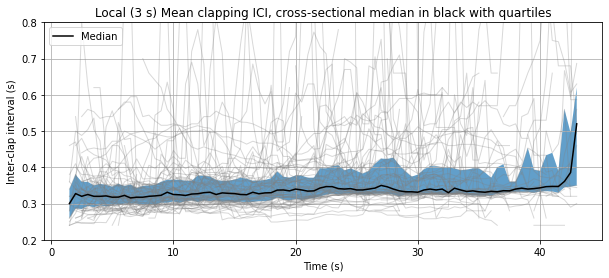

In [68]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

df_feats
fig,ax = plt.subplots(1,1,figsize=[10,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Mean clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('BeethovenApplause_Local_ICI_means_QuartileTS.png',dpi=400)
plt.show()


# Schnittke applause

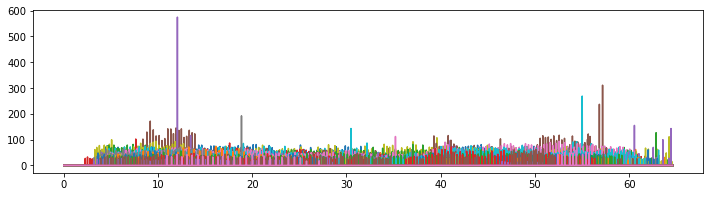

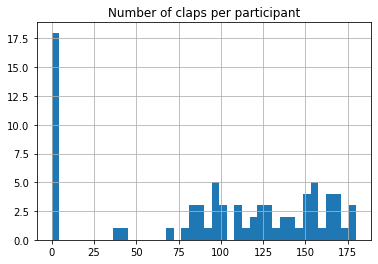

[77, 59]


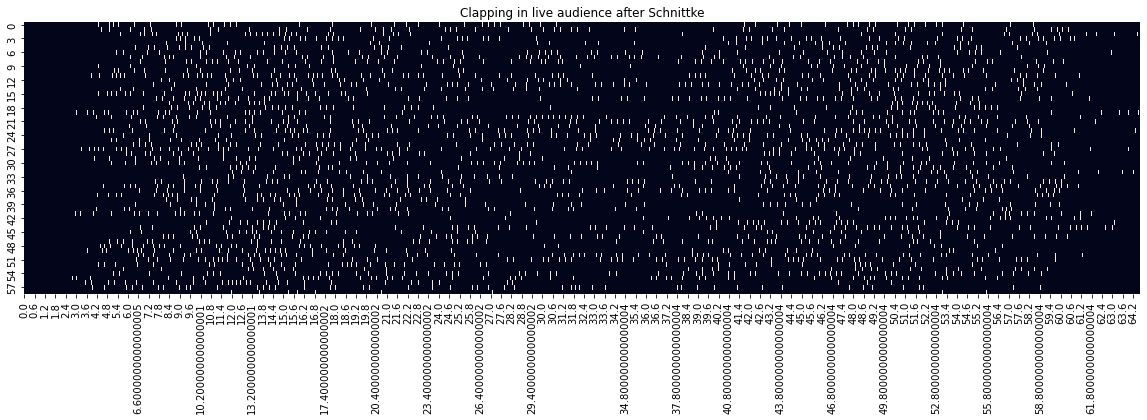

In [158]:
peaks = pd.read_csv('./Data/clapping_data/clapping_peaks/schnittke_peaks.csv')
peaks.drop(columns=['index'],inplace = True)
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.values)
df_claps.plot(figsize = [12,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)

df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_claps.transpose(), ax=ax,vmin=0, vmax=1,cbar=False)
#plt.xticks(concert_times.datetime_concert,concert_times.event, rotation='vertical')
#freq = int(round(len(aud_df)/len(ax.get_xticks())))
#ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Clapping in live audience after Schnittke')
#plt.savefig('claptimes_finale.png')
plt.show()

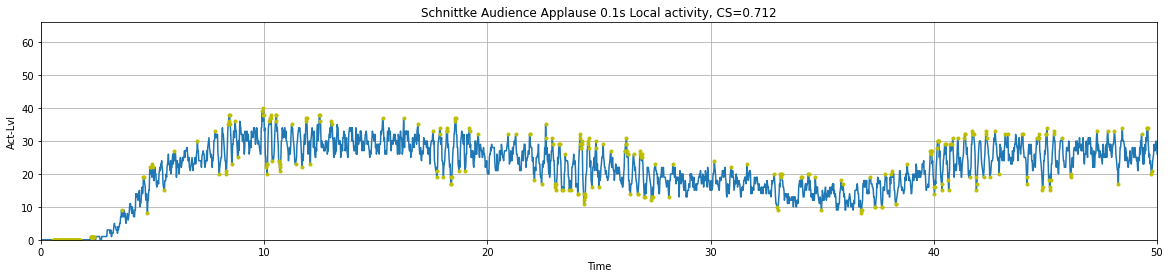

In [138]:
actType = 'UBound'
HopSize = 0.02
Thresh = 0.5
FrameSize = 0.1
# Acts=act.activityCount(df_claps.loc[3:35,:],FrameSize,HopSize,Thresh,actType)
Acts=aa.activityCount(df_claps,FrameSize,HopSize,Thresh,actType)

Acts= Acts.fillna(0)
# include performers
Data = Acts.drop(columns=['Total'])
ShuffleRange = 1
Iter = 1000
alpha = 0.05

stest = aa.localActivityTest(Data,FrameSize,ShuffleRange,Iter,alpha)
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,66])
plt.xlim([0,65])
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Schnittke Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Schnittke_Alignment_01_sub.png',dpi = 400)
plt.show()

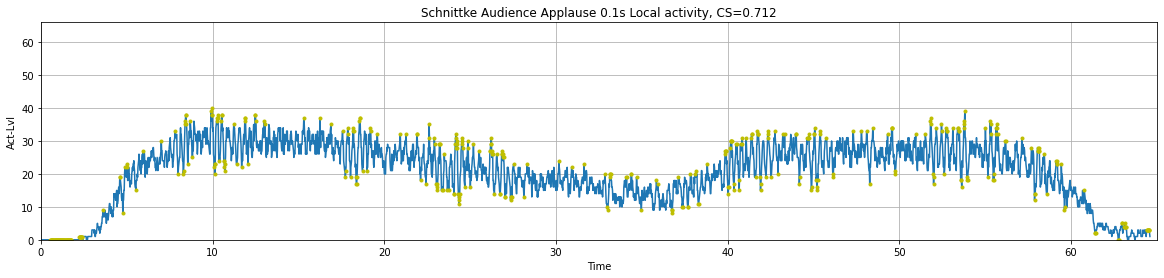

In [139]:
A = stest['MeasuredResults']
B = stest['ActivityPeaks']
C = stest['CoordScore']
# plot the activity levels with local activity peaks
fig = A['Activity-levels'].plot(figsize=[20,4])
if C >=-np.log10(alpha):
    B['Activity-levels'].plot(style='r.')
else:
    B['Activity-levels'].plot(style='y.')
plt.ylim([0,66])
plt.xlim([0,65])
plt.ylabel('Act-Lvl')
plt.grid()
plt.title('Schnittke Audience Applause ' + str(FrameSize) + 's Local activity, CS='+str(round(stest['CoordScore'],3)))
plt.savefig('Applause_Schnittke_Alignment_01_sub.png',dpi = 400)
plt.show()

In [159]:
# build database of clapping behaviour over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
sampletimes = [5, 10, 15, 20, 25, 30,35,40,45,50]
sampleconditions = ['Initial','Initial','Initial','Mid','Mid','Dip','Dip','End','End','End']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)
    
# to_numeric
cols = ['ICI_Mean','ICI_Median','ICI_Quartiles','ICI_STD']
for c in cols:
    Clap_Style.loc[:,c] = pd.to_numeric(Clap_Style[c])

                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.115  2.953  124.047  5.435  0.002


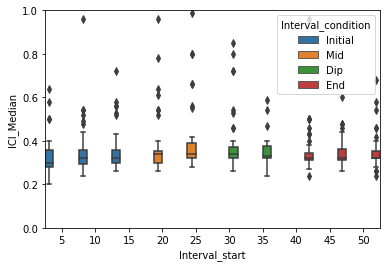

                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.025  2.953  124.047  1.061  0.367


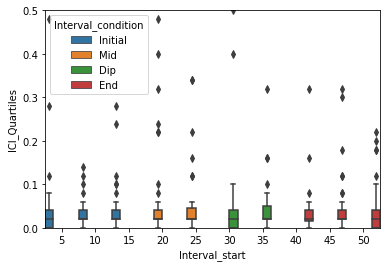

In [141]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.129  2.953  124.047  6.223  0.001


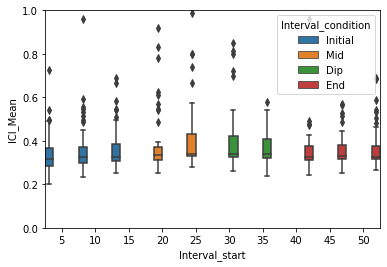

                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.045  2.949  112.051  1.806  0.151


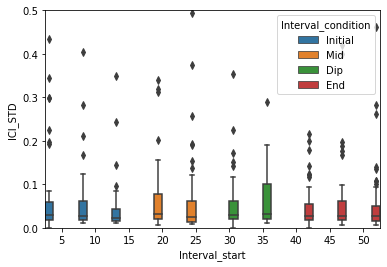

In [142]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Mean', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Mean",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.show()
aov = pg.friedman(dv='ICI_STD', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_STD',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.show()

(0.0, 0.8)

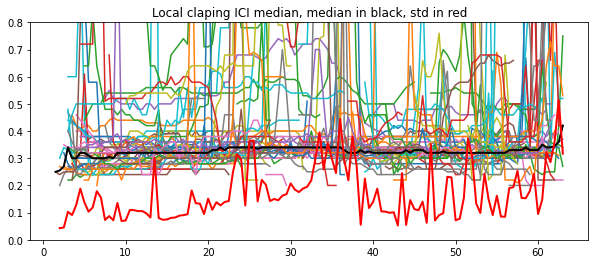

In [160]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0+t_interval,65-t_interval,0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0] = these_claps
Clap_Feats

Clap_Feats.plot(legend=False,figsize=[10,4])
plt.title('Local claping ICI median, median in black, std in red')
B = Clap_Feats.median(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.ylim([0,0.8])

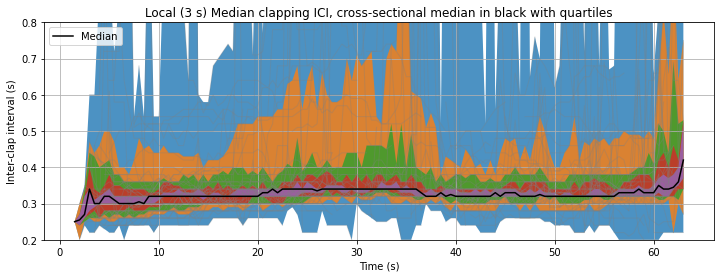

In [161]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
t_interval = 3
cntiles = np.array([0,0.1,0.2,0.3,0.4])
for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

fig,ax = plt.subplots(1,1,figsize=[12,4])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)

for pc in cntiles:
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
            df_spans.loc[i,:] = these_stats
    df_spans = df_spans.dropna()

    x = np.array(df_spans.index)
    y1 = np.array(df_spans.Lower,dtype=np.float32)
    y2 = np.array(df_spans.Upper,dtype=np.float32)
    ax.fill_between(x,y1,y2,alpha = 0.8)

plt.ylim([0.2,0.8])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) Median clapping ICI, cross-sectional median in black with quartiles')
plt.savefig('SchnittkeApplause_Local_ICI_medians_CentileTS.png',dpi=400)
plt.show()


# Clap feats through all clapping intervals
Run through the clapping intervals and if they are longer than 10s, plot out the percentile graphs. 

In [162]:
Clap_files = os.listdir('./Data/clapping_data/clapping_peaks/')
Clap_files

['after_the_introduction_before_the_concert_begins_peaks.csv',
 'a_short_clapping_between_speeches_peaks.csv',
 'bach_peaks.csv',
 'beethoven_peaks.csv',
 'between_frederik_simon_talks_peaks.csv',
 'final_peaks.csv',
 'folk_music_1_peaks.csv',
 'folk_music_2_peaks.csv',
 'folk_music_3_peaks.csv',
 'folk_music_4_peaks.csv',
 'folk_music_5_peaks.csv',
 'musicians_back_after_intermission_peaks.csv',
 'musicians_back_to_stage_for_schnittke_peaks.csv',
 'schnittke_peaks.csv',
 'when_musicians_appear_before_the_introduction_peaks.csv']

In [168]:
ts.iloc[-1]

64.6

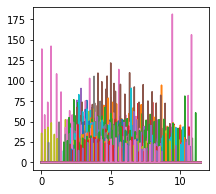

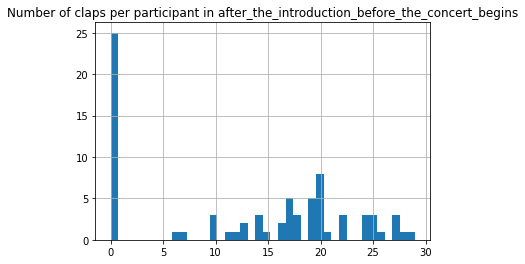

[77, 0.6753246753246753]


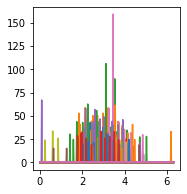

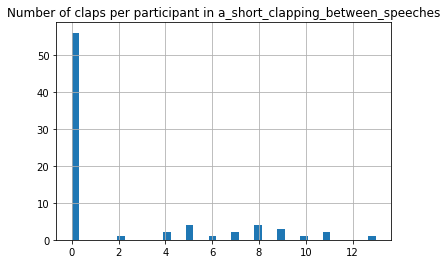

[77, 0.2727272727272727]


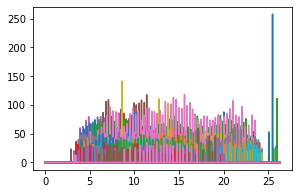

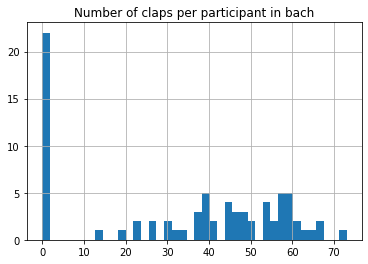

[77, 0.7142857142857143]


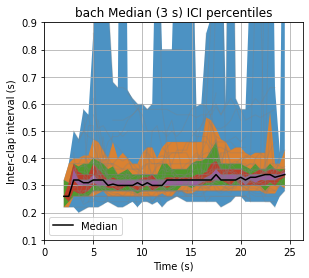

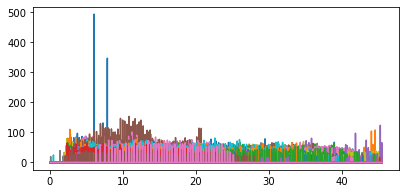

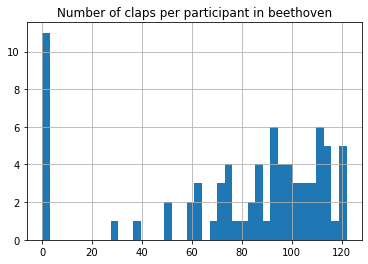

[77, 0.8571428571428571]


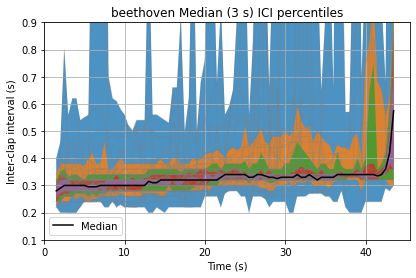

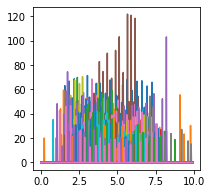

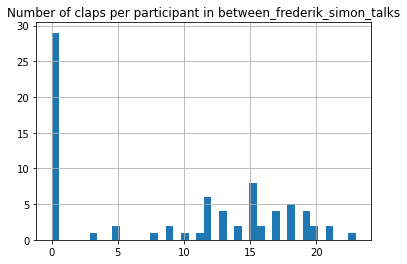

[77, 0.6233766233766234]


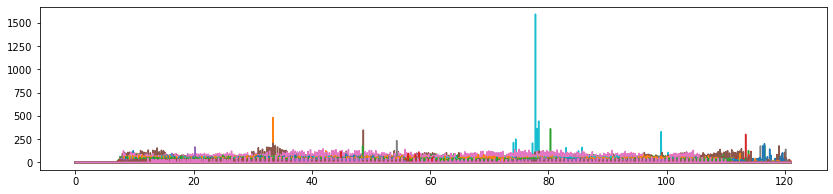

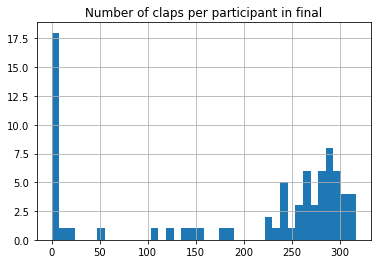

[77, 0.7662337662337663]


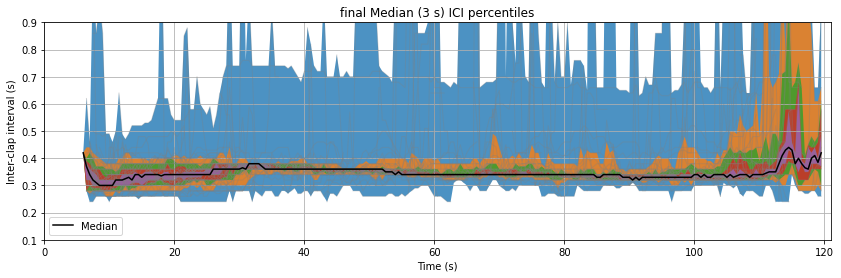

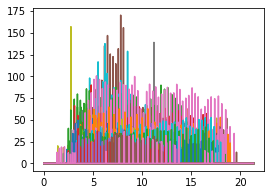

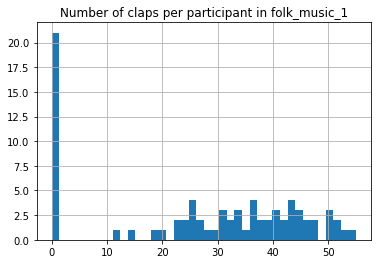

[77, 0.7272727272727273]


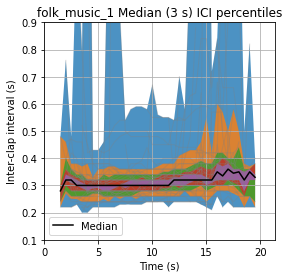

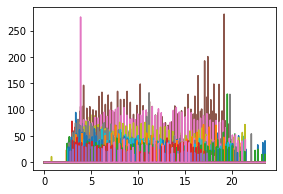

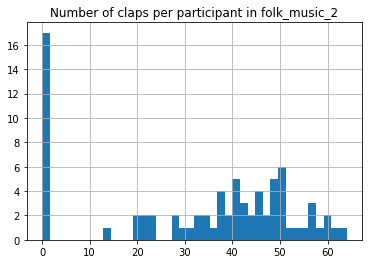

[77, 0.7792207792207793]


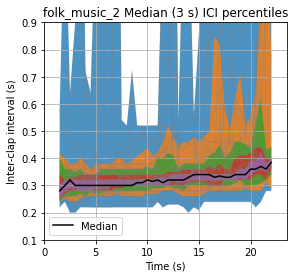

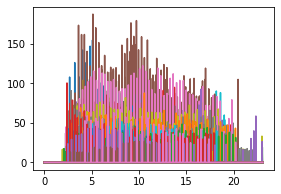

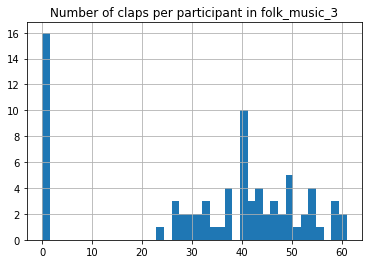

[77, 0.7922077922077922]


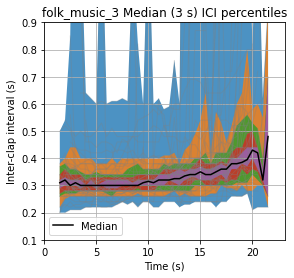

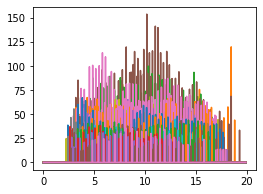

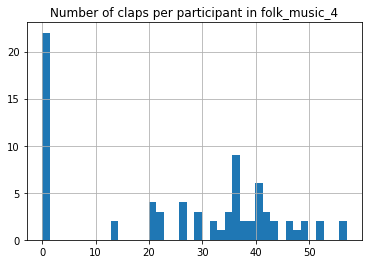

[77, 0.7142857142857143]


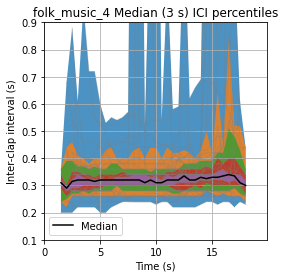

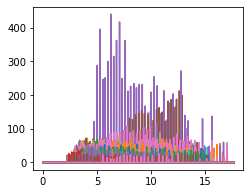

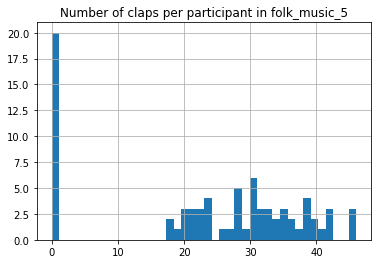

[77, 0.7402597402597403]


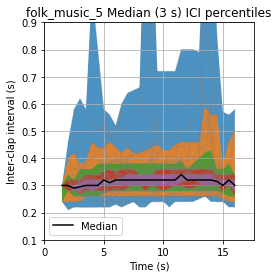

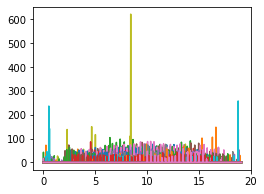

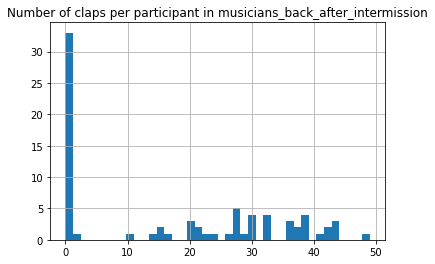

[77, 0.5714285714285714]


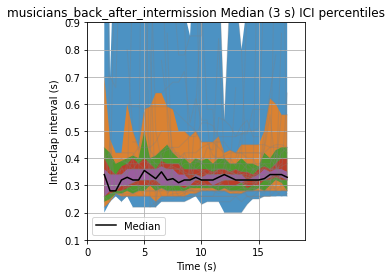

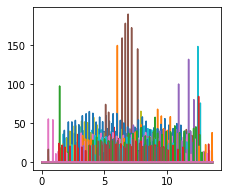

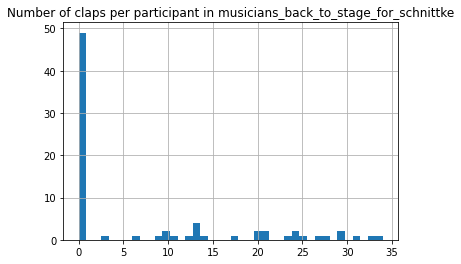

[77, 0.36363636363636365]


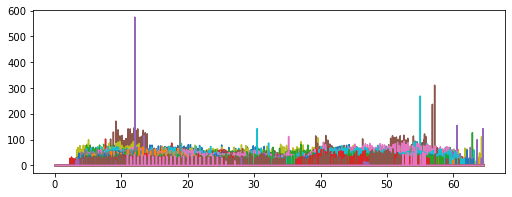

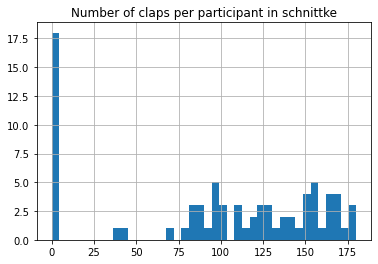

[77, 0.7662337662337663]


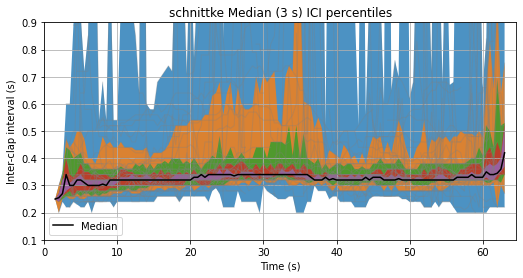

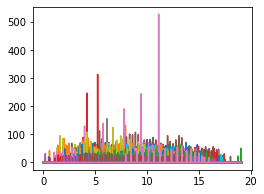

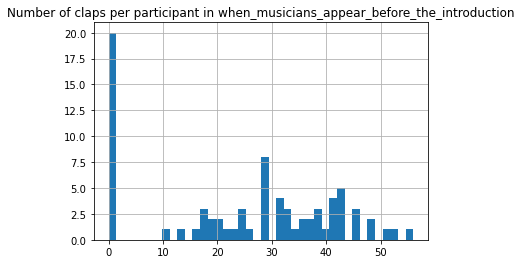

[77, 0.7402597402597403]


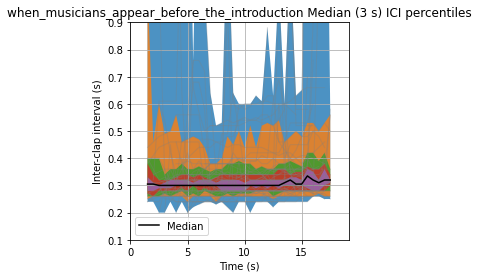

In [172]:
# per file
for filename in Clap_files:
    # read file
    peaks = pd.read_csv('./Data/clapping_data/clapping_peaks/' + filename)
    exp_name = filename[:-10]
    peaks.drop(columns=['index'],inplace = True)
    peaks = peaks.fillna(0)
    ts = pd.Series(np.arange(0,len(peaks))*0.02)
    t_end = ts.iloc[-1]
    
    df_claps = pd.DataFrame(index = ts,data = peaks.values)
    df_claps.plot(figsize = [2+t_end/10,3],legend = False)
    plt.show()
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    df_OnlyClaps.sum().hist(bins = 40)
    plt.title('Number of claps per participant in ' + exp_name)
    plt.show()

    a = df_OnlyClaps.sum().index
    print([len(a),len(a[df_OnlyClaps.sum()>0])/len(a)])
    df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
    df_claps.columns = range(df_claps.columns.size)
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    # Evaluate length or recording 

    if t_end>15:
        # evaluate clapp statistics
        t_interval = 1.5
        sampletimes = np.arange(0+t_interval,t_end-t_interval,0.5)
        Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

        for samp in range(len(sampletimes)):
            t_0 = sampletimes[samp]
            sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
            clap_stats = []
            cols = sub_claps.columns
            these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
            for partn in cols:
                ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
                if ici.notna().sum()>0:
                    these_claps[partn]=np.nanmedian(ici)
            Clap_Feats.loc[t_0] = these_claps
        # plot statistics
        df_A = Clap_Feats.copy()
        df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
        df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
        t_interval = 3
        cntiles = np.array([0,0.1,0.2,0.3,0.4])
        for i, row in df_A.iterrows():
            sub_row = row[row.notna()]
            if len(sub_row)>0:
                these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                               'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
                df_feats.loc[i,:] = these_stats
        df_feats = df_feats.dropna()

        fig,ax = plt.subplots(1,1,figsize=[2+t_end/10,4])
        df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
        #ax.line(df_A.index,df_A)
        df_feats.plot(y='Median',color="black", ax=ax)

        for pc in cntiles:
            for i, row in df_A.iterrows():
                sub_row = row[row.notna()]
                if len(sub_row)>0:
                    these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
                    df_spans.loc[i,:] = these_stats
            df_spans = df_spans.dropna()

            x = np.array(df_spans.index)
            y1 = np.array(df_spans.Lower,dtype=np.float32)
            y2 = np.array(df_spans.Upper,dtype=np.float32)
            ax.fill_between(x,y1,y2,alpha = 0.8)

        plt.ylim([0.1,0.9])
        plt.xlim([0,t_end])
        plt.grid()
        plt.xlabel('Time (s)')
        plt.ylabel('Inter-clap interval (s)')
        plt.title(exp_name +' Median (3 s) ICI percentiles')
        plt.savefig(exp_name+'_Applause_Local_ICI_medians_CentileTS.png',dpi=400)
        plt.show()